In [1]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path


In [2]:
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.3)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [3]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Device:", device)

# Path to training set to get class names
train_dir = r"D:\My Projects\Plant_Disease_Prediction_Custom_CNN\dataset_split\train"
classes = sorted([d.name for d in Path(train_dir).iterdir()])
num_classes = len(classes)

# Load model
model = CustomCNN(num_classes=num_classes).to(device)
model.load_state_dict(torch.load("best_custom_cnn.pth", map_location=device))
model.eval()

✅ Device: cuda


C:\Users\coder\AppData\Local\Temp\ipykernel_24516\3420258329.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_custom_cnn.pth", map

CustomCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.25, inplace=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Dropout(p=0.25, inpla

In [4]:
# Define image transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

def predict_uploaded_image(image):
    input_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        _, pred = torch.max(output, 1)

    predicted_class = classes[pred.item()]

    # Show image with prediction
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"✅ Predicted: {predicted_class}", fontsize=14)
    plt.show()

    return predicted_class

FileUpload(value=(), accept='.jpg,.jpeg,.png', description='Upload')

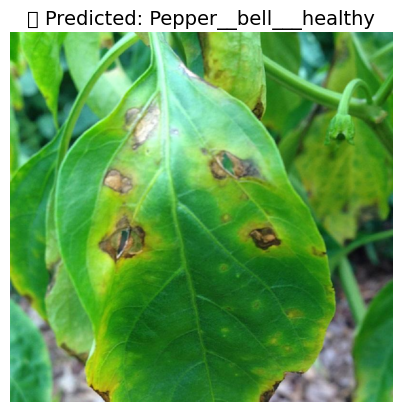

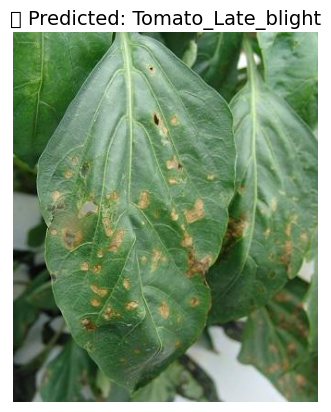

In [5]:
import ipywidgets as widgets
from IPython.display import display
import io

# Upload widget
upload = widgets.FileUpload(accept='.jpg,.jpeg,.png', multiple=False)
display(upload)

# Callback function (fixed for tuple format)
def on_upload_change(change):
    if upload.value:
        file_info = upload.value[0]  # Access the first uploaded file
        image_bytes = file_info['content']
        image = Image.open(io.BytesIO(image_bytes)).convert("RGB")
        print(f"🔍 Uploaded: {file_info['name']}")
        predict_uploaded_image(image)

upload.observe(on_upload_change, names='value')